In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2 as cv

In [31]:
box = np.array([[120, 230, 480, 630], [90, 200, 400, 500]])


In [17]:
def xxyy_to_xyxy(box):
    if len(box.shape) == 1:
        box = np.expand_dims(box, 0)
        print(box.shape)
    if box.shape[-1] != 4:
        box = box.T
    x1, y1, x2, y2 = box[:, 0], box[:, 2], box[:, 1], box[:, 3]
    box = np.array([x1, y1, x2, y2])
    return box.T

In [18]:
bo = xxyy_to_xyxy(box)

In [23]:
def iou_f(box1, box2):
    print(box1)
    print(box2)
    xma = max(box1[..., 0], box2[..., 0])
    yma = max(box1[..., 1], box2[..., 1])
    xmi = min(box1[..., 2], box2[..., 2])
    ymi = min(box1[..., 3], box2[..., 3])

    i_area = abs(max(xma - xmi, 0) * max(yma - ymi, 0))

    box1_area = abs((box1[..., 2] - box1[..., 0]) * (box1[..., 3] - box1[..., 1]))
    box2_area = abs((box2[..., 2] - box2[..., 0]) * (box2[..., 3] - box2[..., 1]))
    result = i_area / float(box2_area + box1_area - i_area)
    return result

In [5]:
list_color = [
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 255, 0],
    [0, 255, 255],
    [255, 0, 255],
    [100, 200, 220],
]


def draw_rec(x1, x2, y1, y2, img_size: int = 640, thickness=3):
    fig, ax = plt.subplots()
    assert (max(x1) <= img_size and max(x2) <= img_size and max(y1) <= img_size and max(
        y2) <= img_size), 'image size must be bigger than coordination or equal'
    frame = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    frame[:, :] = [255, 255, 255]
    print(f'x1, y1, x2, y2 : {x1, y1, x2, y2}')
    for i, (_x1, _x2, _y1, _y2) in enumerate(zip(x1, x2, y1, y2)):
        for h in range(img_size):
            for w in range(img_size):
                if _x1 < w < _x2 and _y1 < h < _y2:
                    if _x1 < w < _x1 + thickness or _y1 < h < _y1 + thickness or _x2 - thickness < w < _x2 or _y2 - thickness < h < _y2:
                        frame[h, w] = list_color[i]

    plt.imshow(frame)
    return frame

x1, y1, x2, y2 : (array([120,  90]), array([480, 400]), array([230, 200]), array([630, 500]))


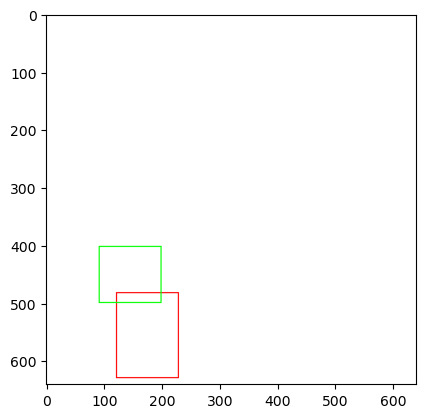

In [6]:
# draw_rec(x1, y1, x2, y2)

In [71]:
torch.max(torch.tensor(120), torch.tensor(90))

tensor(120)

In [63]:
# print(bo.shape)
def bbox_iou(box1, box2, x1y1x2y2=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
    box2 = box2.T

    # Get the coordinates of bounding boxes
    if x1y1x2y2:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
    else:  # transform from xywh to xyxy
        b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
        b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
        b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

    print(f'b1_x1 : {b1_x1}')
    print(f'b1_y1 : {b1_y1}')
    print(f'b1_x2 : {b1_x2}')
    print(f'b1_y2 : {b1_y2}')
    print(f'b2_x1 : {b2_x1}')
    print(f'b2_y1 : {b2_y1}')
    print(f'b2_x2 : {b2_x2}')
    print(f'b2_y2 : {b2_y2}')
    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * (
                torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
    print(f'inter  : {inter}')
    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    union = w1 * h1 + w2 * h2 - inter + eps

    print(f'w1  : {w1}')
    print(f'h1  : {h1}')
    print(f'w2  : {w2}')
    print(f'h2  : {h2}')
    iou = inter / union

    if GIoU or DIoU or CIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 +
                    (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center distance squared
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / (h2 + eps)) - torch.atan(w1 / (h1 + eps)), 2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
        else:  # GIoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + eps  # convex area
            return iou - (c_area - union) / c_area  # GIoU
    else:
        return iou  # IoU


In [94]:
def l_iou(box_1, box_2):
    # box_2 = box_2.T
    b1_x1, b1_y1, b1_x2, b1_y2 = box_1
    b2_x1, b2_y1, b2_x2, b2_y2 = box_2

    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)) * (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1))
    # print(f'inter : {inter}')
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + 1e-7
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + 1e-7
    # print(f'w1 : {w1}')
    # print(f'h1 : {h1}')
    # print(f'w2 : {w2}')
    # print(f'h2 : {h2}')
    # print(f'h2*w2 : {h2 * w2}')
    # print(f'h1*w1 : {h1 * w1}')
    # print(f'w1 * h1 + w2 * h2: {w1 * h1 + w2 * h2}')

    union = w1 * h1 + w2 * h2 - inter + 1e-7
    # print(f'union  :  {union}')
    iou_ = inter / union
    print(iou_)
    print('-' * 50)
    return iou_

In [83]:
import torch

b1_ = torch.from_numpy(box[0])
b2_ = torch.from_numpy(box[1])
l_iou(b1_, b2_)
bbox_iou(b1_, b2_, x1y1x2y2=True)

tensor(0.4684)
--------------------------------------------------
b1_x1 : 120
b1_y1 : 230
b1_x2 : 480
b1_y2 : 630
b2_x1 : 90
b2_y1 : 200
b2_x2 : 400
b2_y2 : 500
inter  : 75600
w1  : 360
h1  : 400.0
w2  : 310
h2  : 300.0


tensor(0.4684)

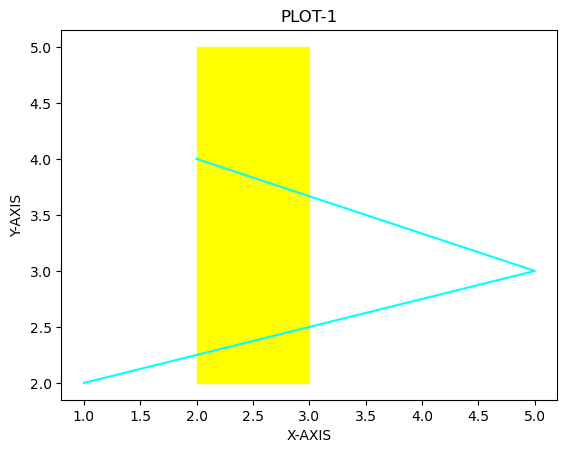

In [49]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.plot([1, 5, 2], [2, 3, 4], color="cyan")
ax.add_patch(Rectangle((2, 2), 1, 3, color="yellow"))
plt.xlabel("X-AXIS")
plt.ylabel("Y-AXIS")
plt.title("PLOT-1")
plt.show()

In [72]:
inter = (120 - 400) * (230 - 500)

In [73]:
inter

75600

In [74]:
union = (110 * 150) + (310 * 300) - inter

In [75]:
union

33900

In [76]:
inter / union

2.230088495575221

In [95]:
box_1_ = torch.tensor([120, 230, 480, 630])
box_2_ = torch.tensor([90, 200, 400, 500])
l_iou(box_1_, box_2_)

tensor(0.4684)
--------------------------------------------------


tensor(0.4684)

In [96]:
union = 237000-75600

In [97]:
inter = 75600

In [ ]:
# inter / union
import torch
print(torch.__version__)